In [1]:
import numpy as np
import math
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import torch
from PINN import PINN

In [2]:
%load_ext autoreload
%autoreload 2

# 1D examples 
#### Source: https://www.cantorsparadise.com/the-heat-equation-a76d7773a0b5

## 1)  An insulated, meter-long bar with k/ρc = \alpha =0.1m²/s (unrealistic but easier for graphing purposes) is initially 100°C throughout its length before cooling elements set to 0°C are clamped to its ends at t=0

In [3]:
# Closed-Form Solution
alpha = 0.1
num_series_terms = 500
x = np.linspace(0, 1, num = 50)
t = np.linspace(0, 0.5, num = 50)
u = np.zeros((t.shape[0], x.shape[0]))

for i, x_i in enumerate(x):
    for j, t_j in enumerate(t):
        u[j,i] = 0
        for n in range(1,num_series_terms+1):
            u[j,i] += 200/(math.pi * n) * ((-1)**(n+1) + 1) * math.sin(n*math.pi*x_i) * math.exp(-alpha*(n**2)*(math.pi**2)*t_j) 

/Users/Manel/.virtualenvs/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


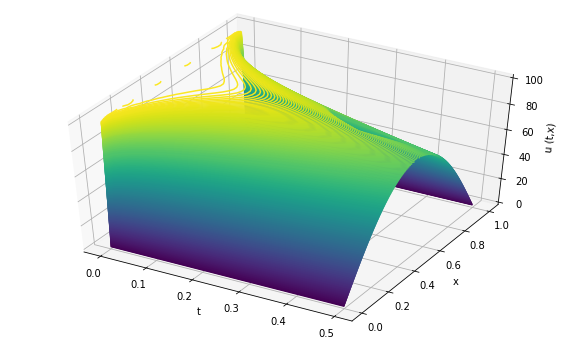

In [4]:
# 3D Plotting the Closed-Form Solution
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
T, X = np.meshgrid(t,x)
ax.contour3D(T, X, u.T, 400, cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u (t,x)');
ax.view_init(45, -60)

N_collocation: 250, N_boundary: 2, N_test: 50


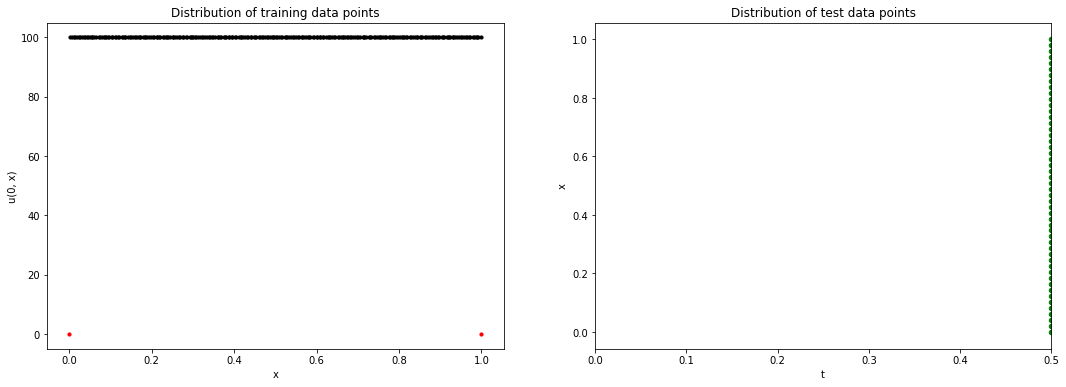

In [5]:
# SEE TRAINING DATA POINTS DISTRIBUTION

# Load datasets and problem data (diffusivity and dimension)
PATH = "./1D_simplebar_dataset"
checkpoint = torch.load(PATH)
x_train = checkpoint['x_train']
y_train = checkpoint['y_train']
x_test = checkpoint['x_test']
y_test = checkpoint['y_test']
input_size = checkpoint['input_size']
alpha = checkpoint['alpha']
x_boundaries = checkpoint['x_boundaries']
t_boundaries = checkpoint['t_boundaries']
delta_t = checkpoint['delta_t']
N_test = checkpoint['N_test']
N_collocation = checkpoint['N_collocation']
N_boundary = checkpoint['N_boundary']

# Amount of boundary, collocation and test points
print(f"N_collocation: {N_collocation}, N_boundary: {N_boundary}, N_test: {N_test}")

# Plotting the point distribution in (t,x) to observe the distribution of the data generated
fig = plt.figure(figsize=(18,6))

# Left plot: boundary points in red, collocation points in black
ax1 = fig.add_subplot(121)
ax1.scatter(x_train[:N_boundary,:].detach().numpy(), y_train[:N_boundary,:].detach().numpy(), color = 'red',marker= 'o', s=10)
ax1.scatter(x_train[N_boundary:,:].detach().numpy(), y_train[N_boundary:,:].detach().numpy(), color = 'black',marker= 'o', s=10)
ax1.set_title('Distribution of training data points')
ax1.set_xlabel('x')
ax1.set_ylabel('u(0, x)')

# Right plot: you can see a grid of points (the one we used above to compute the closed-form solution)
# We will compare the results obtained in the closed-form in the grid to the ones obtained by the NN 
# in those points
ax2 = fig.add_subplot(122)
ax2.scatter(delta_t * np.ones((N_test,1)), x_test[:,0].detach().numpy(), color = 'green', s=20)
ax2.set_title('Distribution of test data points')
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_xlim(t_boundaries)

plt.show()

In [6]:
# SEE MODEL PREDICTION

# INITIAL MODEL (NO TRAINING, ONLY INITIALIZED)
# Load model
PATH = "initial_model"
checkpoint = torch.load(PATH)
model_dict = checkpoint['model_dict']
hidden_sizes = checkpoint['hidden_sizes']
output_size = checkpoint['output_size']
model_times = checkpoint['model_times']
delta_t = checkpoint['delta_t']
alpha = checkpoint['alpha']

model1 = PINN(h_sizes=hidden_sizes, out_size=output_size, delta_t=delta_t, alpha=alpha)
model1.load_state_dict(model_dict)
model1.eval()

# Evaluate model in the grid
u_model1 = np.zeros((model_times.shape[0], x_test.shape[0]))
for i, x_i in enumerate(x_test):
    u_model1[:, i] = model1(x_i).detach().numpy()# note that u^{n+cj} = u(t_n + c_j*h, x), so the output 
    # from the neural network outputs the evolution of u along time for a given input x. Following this reasoning
    # we plot the predicted u(t,x) by the PINN

interpolation/integration for butcher tableau - max error: 1.4863712304395882e-08


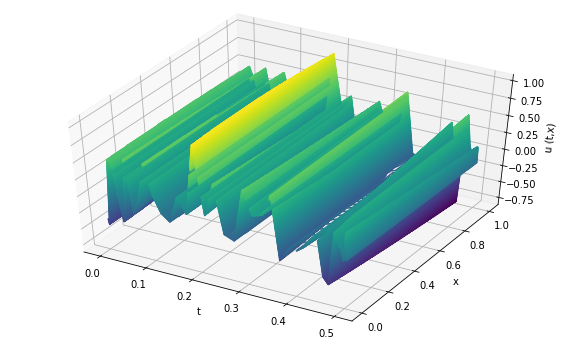

In [7]:
# 3D Plotting the solution from initial model
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
T, X = np.meshgrid(model_times, x_test)
ax.contour3D(T, X, u_model1.T, 400, cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u (t,x)');
ax.view_init(45, -60)

# TERRIBLE!

In [8]:
# AFTER TRAINING
# Load model
PATH = "final_model1"
checkpoint = torch.load(PATH)
model_dict = checkpoint['model_dict']
hidden_sizes = checkpoint['hidden_sizes']
output_size = checkpoint['output_size']

model2 = PINN(h_sizes=hidden_sizes, out_size=output_size, delta_t=delta_t, alpha=alpha)
model2.load_state_dict(model_dict)
model2.eval()

# Evaluate model in the grid
u_model2 = np.zeros((model_times.shape[0], x_test.shape[0]))
for i, x_i in enumerate(x_test):
    u_model2[:, i] = model2(x_i).detach().numpy() # note that u^{n+cj} = u(t_n + c_j*h, x), so the output 
    # from the neural network outputs the evolution of u along time for a given input x. Following this reasoning
    # we plot the predicted u(t,x) by the PINN

interpolation/integration for butcher tableau - max error: 1.4863712304395882e-08


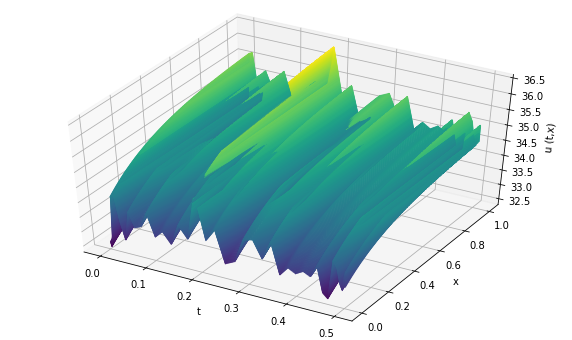

In [9]:
# 3D Plotting the solution from final model
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
T, X = np.meshgrid(model_times, x_test)
ax.contour3D(T, X, u_model2.T, 400, cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u (t,x)');
ax.view_init(45, -60)

# only main difference is on the y axis values... 